# **Motorbike Ambulance Calls**
>Motorbike accidents and corresponded ambulance calls are highly depended on environmental and seasonal settings, like weather conditions, precipitation, day of week, season, hour of the day, etc. The data was aggregated over the course of two years, on hourly basis, and then extracted and extended with the corresponding weather and seasonal information.


## **Associated tasks**

---


**Regression**

Prediction of the hourly ambulance calls count based on the environmental and seasonal settings. Prediction model should provide monotonic in the terms of some features, if it is proved by data.

**Event and Anomaly Detection**

Define the  ambulance calls patterns with respect of special events and define the cases that might be considered as abnormal behavior.  

**Deliverables**

Full Texts Report that contains detail description of Data Analysis, Data Modelling and Patterns/Anomaly detection processes with conclusions and their explanations.
What is important here:
* See the **way you’re thinking** – what actions you’re implementing and why
* How **you code** and wrangle the data
* **Storytelling** capabilities – so we’re looking for the full-text structured report separately from the code/notebook
* **Suggestions** on the further  analytics/approaches which could be applied

## **Dataset characteristics:**

---



motorbike_ambulance_calls.csv has the following fields:

              - index: record index
              - date : date
              - season : season (1:springer, 2:summer, 3:fall, 4:winter)
              - yr : year (0: 2011, 1:2012)
              - mnth : month ( 1 to 12)
              - hr : hour (0 to 23)
              - holiday : whether day is holiday or not
              - weekday : day of the week
              - workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
              -  weathersit :
                      - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
                      - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
                      - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
                      - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
              - temp : Normalized temperature in Celsius. The values are divided to 41 (max)
              - atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
              - hum: Normalized humidity. The values are divided to 100 (max)
              - windspeed: Normalized wind speed. The values are divided to 67 (max)
              - cnt: count of total ambulance calls


In [96]:
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pylab import rcParams
from sklearn.preprocessing import LabelEncoder
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

rcParams['figure.figsize'] = 10, 6
rcParams['font.size'] = 14



At the first stage, we import the necessary libraries, disable warnings to avoid unnecessary output, and configure key parameters for plots and ease of work.

In [97]:
motorbike_ambulance_calls = pd.read_csv('motorbike_ambulance_calls.csv')
motorbike_ambulance_calls.head()

,index,date,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1/1/11,spring,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,2,1/1/11,spring,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,3,1/1/11,spring,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,4,1/1/11,spring,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,5,1/1/11,spring,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


At the next stage, we load the dataset and display the first few rows to familiarize ourselves with its structure.

In [98]:
motorbike_ambulance_calls['time_period'] = motorbike_ambulance_calls['hr'].apply(lambda x: 'Night' if x < 6 or x >= 18 else 'Day')


Now we add a new feature, time_period, which classifies each record as “Day” or “Night” depending on the time of day.

In [99]:
label_encoder = LabelEncoder()
for column in ['season', 'yr', 'holiday', 'weekday', 'workingday', 'weathersit', 'time_period']:
    motorbike_ambulance_calls[column] = label_encoder.fit_transform(motorbike_ambulance_calls[column])

Here we perform encoding of categorical variables using LabelEncoder to enhance the efficiency of model training. All specified columns are converted into numerical values.

In [100]:
numerical_columns = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']
categorical_columns = ['season', 'yr', 'holiday', 'weekday', 'workingday', 'weathersit', 'time_period']


Now we split the variables into numerical and categorical ones and store them in lists for convenience in the subsequent steps.

In [101]:
motorbike_ambulance_calls.head()

,index,date,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,time_period
0,1,1/1/11,1,0,1,0,0,6,0,0,0.24,0.2879,0.81,0.0,16,1
1,2,1/1/11,1,0,1,1,0,6,0,0,0.22,0.2727,0.80,0.0,40,1
2,3,1/1/11,1,0,1,2,0,6,0,0,0.22,0.2727,0.80,0.0,32,1
3,4,1/1/11,1,0,1,3,0,6,0,0,0.24,0.2879,0.75,0.0,13,1
4,5,1/1/11,1,0,1,4,0,6,0,0,0.24,0.2879,0.75,0.0,1,1


Let’s take another look at our data.

In [102]:
print('Shape:',motorbike_ambulance_calls.shape)
print('Size:',motorbike_ambulance_calls.size)

Shape: (17379, 16)
Size: 278064


We evaluate the shape of the data by checking its dimensions using shape (number of rows and columns) and size (total number of elements).

In [103]:
missing_values = motorbike_ambulance_calls.isnull().sum()
print('Missing values:')
print(missing_values.to_string())

Missing values:
index          0
date           0
season         0
yr             0
mnth           0
hr             0
holiday        0
weekday        0
workingday     0
weathersit     0
temp           0
atemp          0
hum            0
windspeed      0
cnt            0
time_period    0


A check for missing data showed that there are none. This is a great feature because the data is ready for further processing without having to fill or delete it.

In [104]:
motorbike_ambulance_calls.describe()

,index,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,time_period
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,1.482019,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,0.425283,0.496987,0.475775,0.627229,0.190098,189.463088,0.497382
std,5017.0295,1.119902,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,181.387599,0.500008
min,1.0000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,4345.5000,0.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,0.000000,0.340000,0.333300,0.480000,0.104500,40.000000,0.000000
50%,8690.0000,1.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,0.000000,0.500000,0.484800,0.630000,0.194000,142.000000,0.000000
75%,13034.5000,2.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,1.000000,0.660000,0.621200,0.780000,0.253700,281.000000,1.000000
max,17379.0000,3.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,3.000000,1.000000,1.000000,1.000000,0.850700,977.000000,1.000000


The data are evenly distributed over years, months and days. Most variables, such as temperature, humidity, and wind speed, have normalized values, which simplifies further processing

In [105]:
print(motorbike_ambulance_calls.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        17379 non-null  int64  
 1   date         17379 non-null  object 
 2   season       17379 non-null  int64  
 3   yr           17379 non-null  int64  
 4   mnth         17379 non-null  int64  
 5   hr           17379 non-null  int64  
 6   holiday      17379 non-null  int64  
 7   weekday      17379 non-null  int64  
 8   workingday   17379 non-null  int64  
 9   weathersit   17379 non-null  int64  
 10  temp         17379 non-null  float64
 11  atemp        17379 non-null  float64
 12  hum          17379 non-null  float64
 13  windspeed    17379 non-null  float64
 14  cnt          17379 non-null  int64  
 15  time_period  17379 non-null  int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 2.1+ MB
None


I display information about the dataset: column names, their data types, and the number of non-null values. This allows for a quick check for missing data and an assessment of the memory usage of the table.

In [106]:
motorbike_ambulance_calls = pd.get_dummies(motorbike_ambulance_calls, columns=['weekday'], prefix='day')


for col in motorbike_ambulance_calls.select_dtypes(include='bool').columns:
    motorbike_ambulance_calls[col] = motorbike_ambulance_calls[col].astype(int)

print(motorbike_ambulance_calls.head())

categorical_columns = motorbike_ambulance_calls.select_dtypes(include=['object']).columns

   index    date  season  yr  mnth  hr  holiday  workingday  weathersit  temp  \
0      1  1/1/11       1   0     1   0        0           0           0  0.24   
1      2  1/1/11       1   0     1   1        0           0           0  0.22   
2      3  1/1/11       1   0     1   2        0           0           0  0.22   
3      4  1/1/11       1   0     1   3        0           0           0  0.24   
4      5  1/1/11       1   0     1   4        0           0           0  0.24   

   ...  windspeed  cnt  time_period  day_0  day_1  day_2  day_3  day_4  day_5  \
0  ...        0.0   16            1      0      0      0      0      0      0   
1  ...        0.0   40            1      0      0      0      0      0      0   
2  ...        0.0   32            1      0      0      0      0      0      0   
3  ...        0.0   13            1      0      0      0      0      0      0   
4  ...        0.0    1            1      0      0      0      0      0      0   

   day_6  
0      1  
1   

converts the weekday column to dummy variables, creating separate binary columns for each value. Boolean columns (bool) are changed to numeric type (int) for data consistency.

We will convert the weekday column to dummy variables by creating separate binary columns for each value and then convert the bool columns to int.

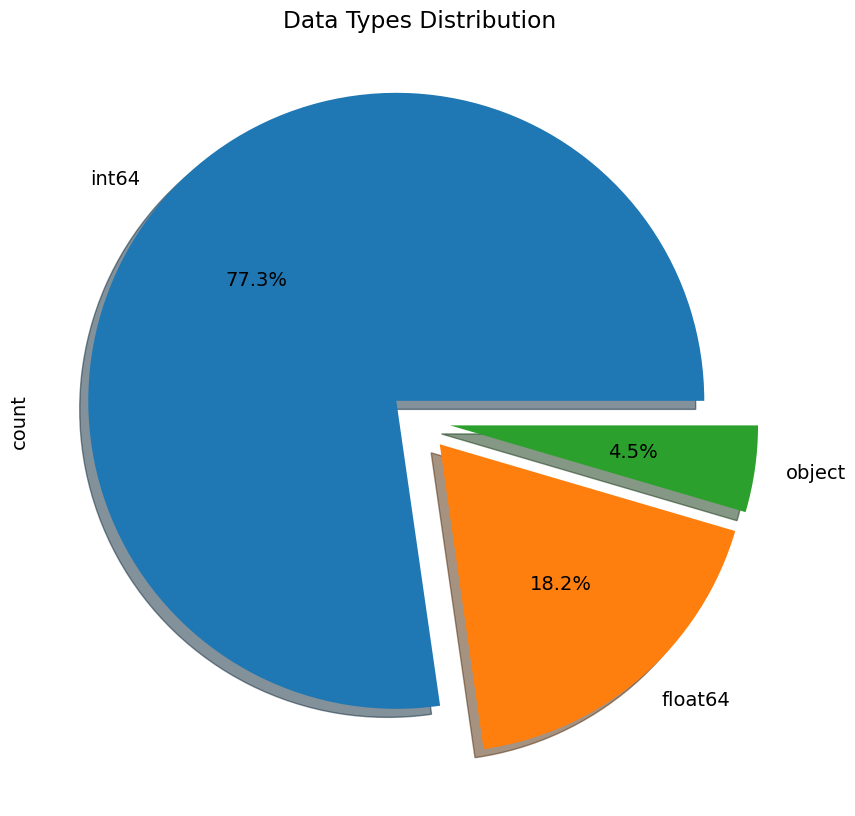

In [107]:
motorbike_ambulance_calls.dtypes.value_counts().plot.pie(subplots=True, figsize=(10, 10), autopct='%1.1f%%', shadow=True, explode=[0.1, 0.1, 0.1])
plt.title('Data Types Distribution')
plt.show()


Now 77% of the columns are of type int, 4.5% are of type bool, and the remaining 18% are of type float. This is a good balance for further data usage.

In [108]:
skewness = motorbike_ambulance_calls[numerical_columns].apply(lambda x: skew(x))
kurtosis_values = motorbike_ambulance_calls[numerical_columns].apply(lambda x: kurtosis(x))

print("Skewness:")
print(skewness.to_string())
print('-'*50)
print("Kurtosis:")
print(kurtosis_values.to_string())


Skewness:
temp        -0.006020
atemp       -0.090421
hum         -0.111278
windspeed    0.574856
cnt          1.277301
--------------------------------------------------
Kurtosis:
temp        -0.941918
atemp       -0.845514
hum         -0.826224
windspeed    0.590305
cnt          1.416450


So now the skewness and kurtosis results of the data. Most of the variables, for example temp, atemp and hum, have a small asymmetry, which indicates an almost normal distribution of the data, which is good because machine learning models work better with such data. But windspeed and, especially, cnt have a greater asymmetry.

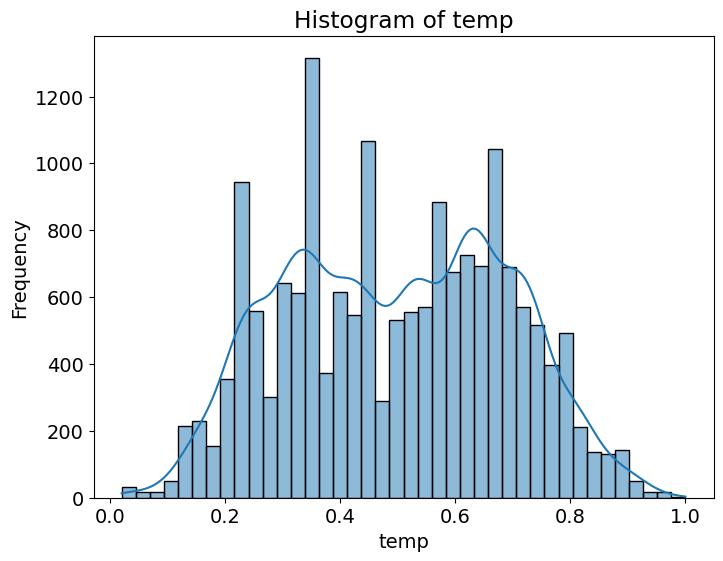

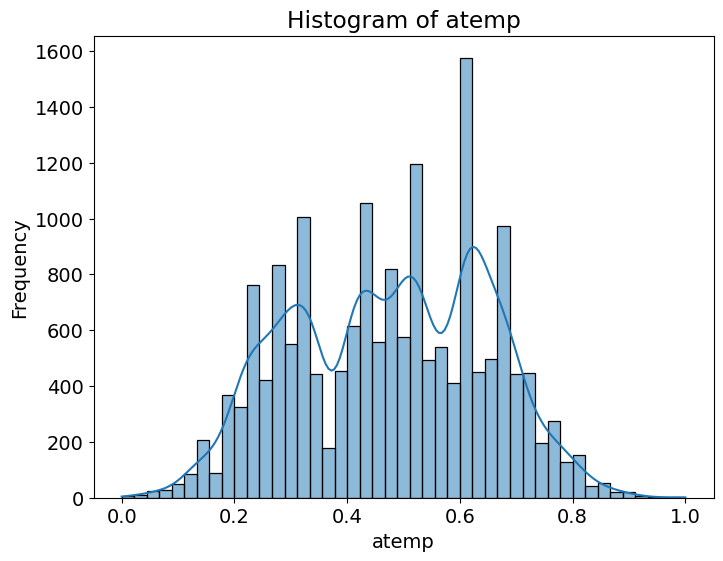

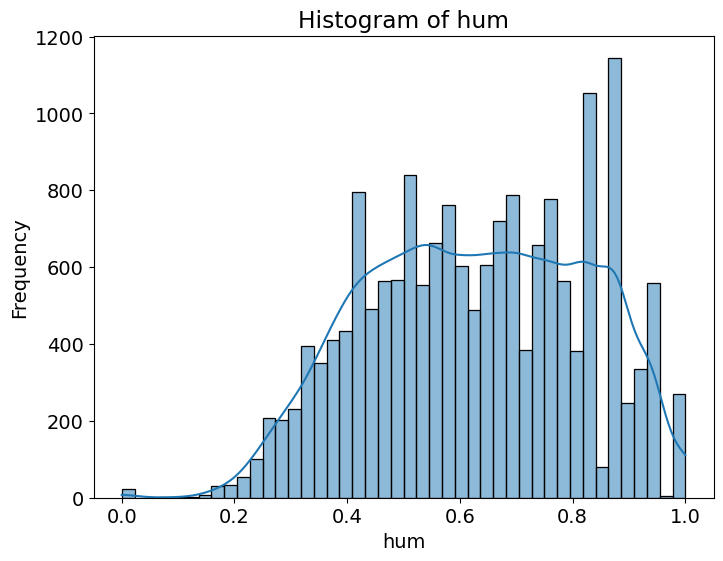

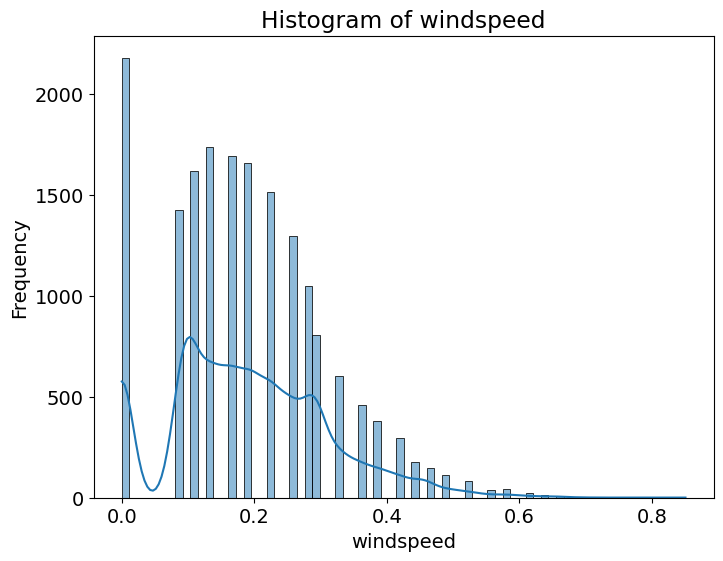

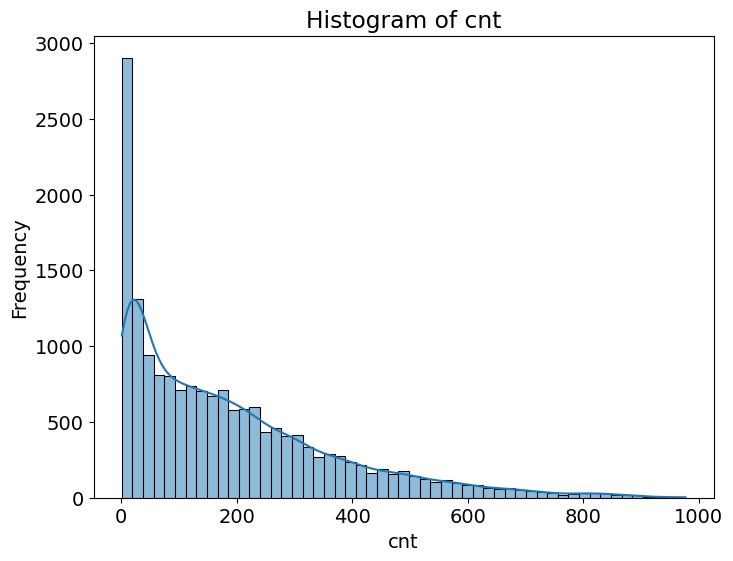

In [109]:
for col in numerical_columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(motorbike_ambulance_calls[col], kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

- The histogram for the variable temp shows a close to symmetric distribution with several peaks, which indicates a clustering of values. The data distribution is bell-shaped.
- The air temperature histogram is very similar to the temperature histogram.
- The humidity histogram has a heavy right tail and this indicates a positive asymmetry. This means that there is a tendency for high humidity in most calls.
- The histogram for the windspeed variable shows a pronounced positive asymmetry with a heavy right tail. Most values ​​are concentrated in the low range, and the frequency of values ​​decreases with increasing wind speed. This indicates that low wind speed is dominant in the data.
- The histogram for the cnt variable shows a strong positive skewness with a heavy right tail, which means that the low number of calls dominates.

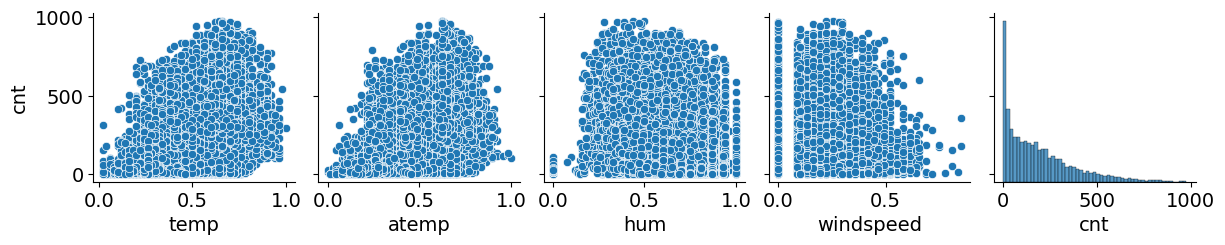

In [110]:
sns.pairplot(motorbike_ambulance_calls, x_vars=numerical_columns, y_vars='cnt', kind='scatter')
plt.show()

- A significant dependence of temp and atemp is noticeable on the scatterplot where x is a numerical variable and y is cnt.
- In humidity, the distribution of values ​​is almost uniform.
- Wind speed shows a scattered distribution, which indicates a weak influence of wind speed on the number of calls.

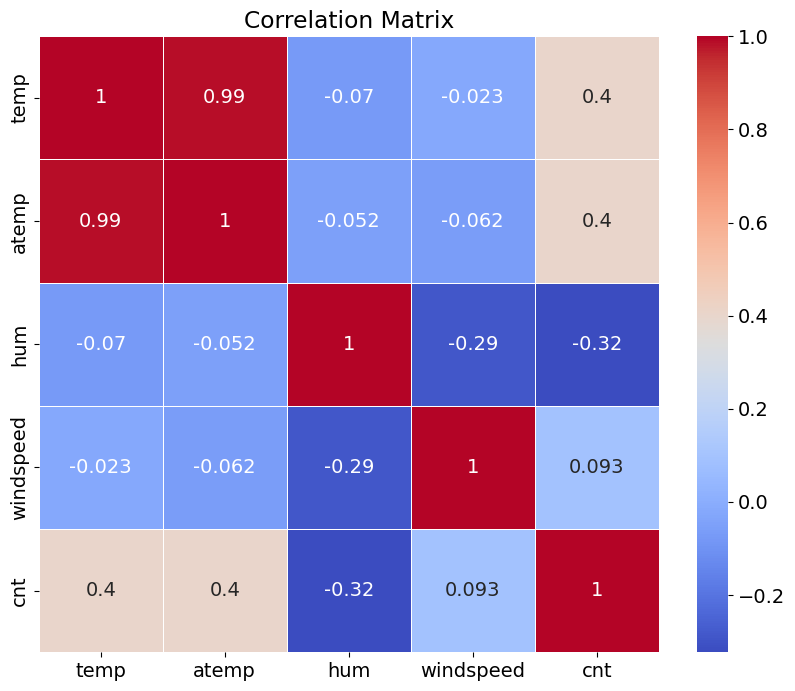

In [111]:
corr_matrix = motorbike_ambulance_calls[numerical_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

- Strong positive correlation between temp and atemp (0.99), which means that these variables are almost linearly dependent on each other.
- High correlation between traits can lead to multicollinearity, which can degrade model performance.
- Positive correlation between temp and cnt (0.4), showing that the number of calls increases with increasing temperature.

In [112]:
top_correlated = corr_matrix['cnt'].sort_values(ascending=False).iloc[1:4]
print("Top 3 features correlated with target:")
print(top_correlated.to_string())

Top 3 features correlated with target:
temp         0.404772
atemp        0.400929
windspeed    0.093234


Temperature and air temperature were most correlated with cnt.

In [113]:
motorbike_ambulance_calls = motorbike_ambulance_calls.drop(columns=['atemp'])
numerical_columns = ['temp', 'hum', 'windspeed', 'cnt']


So I decided to remove atemp to prevent multicollinearity.

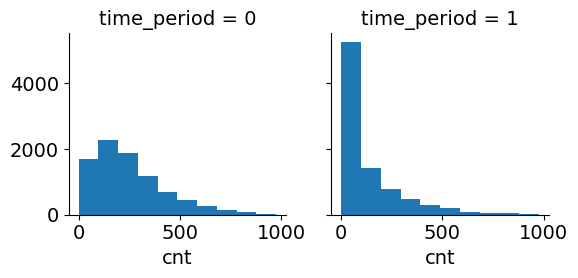

In [114]:
g = sns.FacetGrid(motorbike_ambulance_calls, col='time_period')
g = g.map(plt.hist, "cnt")


- The distribution at night is wider with a significant number of calls in the middle range but there are also higher values ​​indicating greater activity at night
- During the day, most calls are concentrated in the lower range, which indicates less activity during the day.

yr
2012    8734
2011    8645
Name: count, dtype: int64


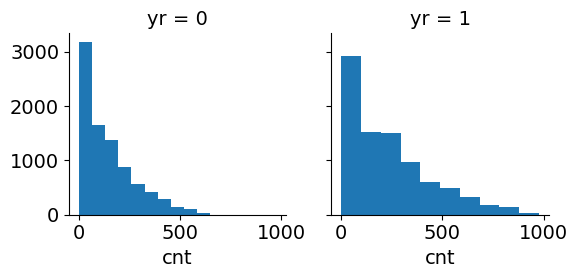

In [115]:
years = motorbike_ambulance_calls['yr'].map({0: 2011, 1: 2012})
print(years.value_counts())

g = sns.FacetGrid(motorbike_ambulance_calls, col='yr')
g = g.map(plt.hist, "cnt")


- The distributions between years are almost identical, which indicates the stability of trends in the data during these two years.
- Both years are dominated by calls with a low cnt count (cnt < 200), with a right heavy tail present.

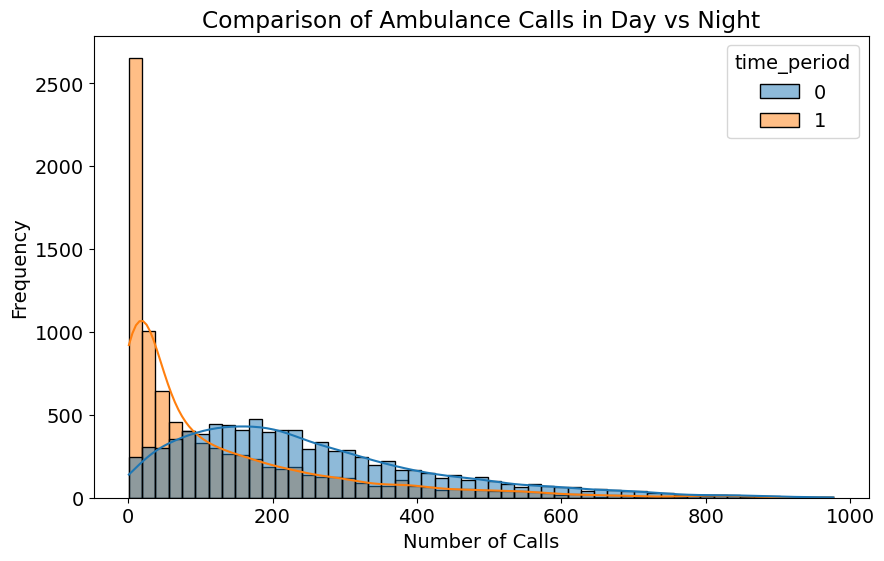

In [116]:
plt.figure(figsize=(10, 6))
sns.histplot(data=motorbike_ambulance_calls, x='cnt', hue='time_period', kde=True)
plt.title('Comparison of Ambulance Calls in Day vs Night')
plt.xlabel('Number of Calls')
plt.ylabel('Frequency')
plt.show()


Now let's compare the number of calls during the day (time_period=1) and at night (time_period=0).
- During the day, most calls are concentrated in the low range. The distribution shows a clear peak with a rapid decline indicating a mostly low number of calls per day.
- At night, the distribution is wider with a more uniform distribution in the average values, which means that the number of calls may vary more at night.

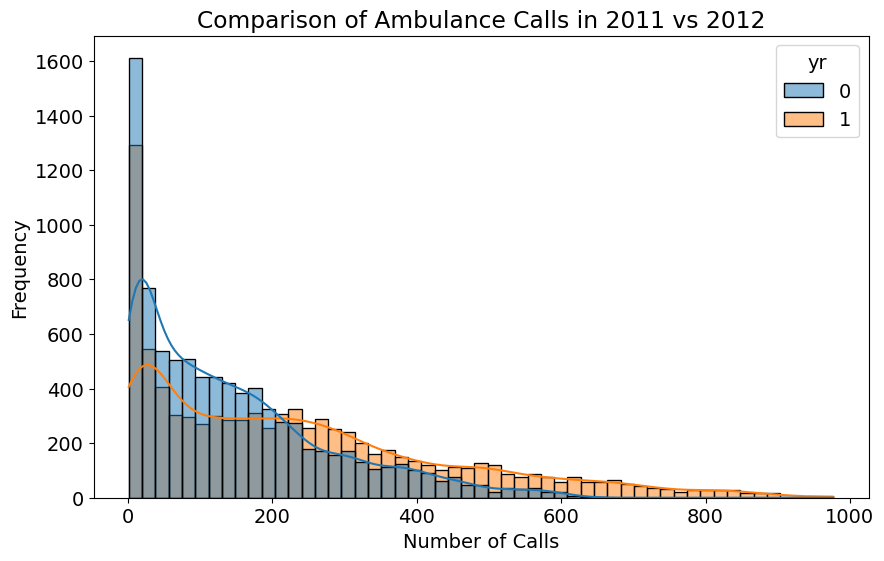

In [117]:
plt.figure(figsize=(10, 6))
sns.histplot(data=motorbike_ambulance_calls, x='cnt', hue='yr', kde=True)
plt.title('Comparison of Ambulance Calls in 2011 vs 2012')
plt.xlabel('Number of Calls')
plt.ylabel('Frequency')
plt.show()

If we compare the values ​​for 2011-2012. then you can see that in 2011 the distribution has a larger peak in the lower range up to 100 calls. In 2012 the distribution was more uniform with a slightly less pronounced peak and the frequency in the middle ranges (200–400 calls) was higher than in 2011. In general, in 2012 the number of calls was slightly more evenly distributed.

In [118]:
yearly_stats = motorbike_ambulance_calls.groupby('yr')['cnt'].describe()
print("Summary statistics for ambulance calls by year:")
print(yearly_stats.to_string())


Summary statistics for ambulance calls by year:
     count        mean         std  min   25%    50%    75%    max
yr                                                                
0   8645.0  143.794448  133.797854  1.0  31.0  109.0  211.0  651.0
1   8734.0  234.666361  208.910941  1.0  53.0  191.0  347.0  977.0


In 2012, there was a significant increase in the average and maximum number of calls, and the variability increased.

And now it's time to scale the data.


In [119]:
not_scaled_data = motorbike_ambulance_calls[numerical_columns].copy()

scaler = StandardScaler()
motorbike_ambulance_calls[numerical_columns] = scaler.fit_transform(motorbike_ambulance_calls[numerical_columns])

We use StandardScaler. And we also save old data for comparison. We do this in order to make the data more suitable for analysis

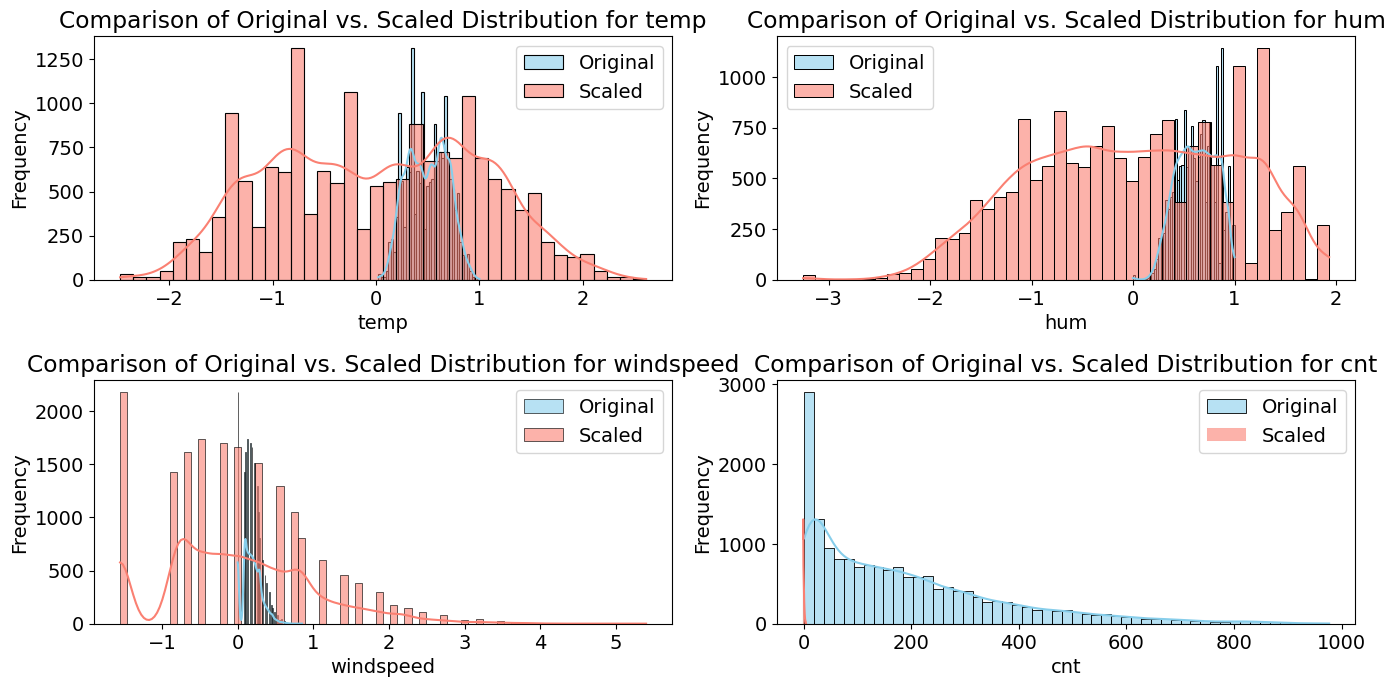

In [120]:

plt.figure(figsize=(14, 10))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 2, i)
    
    sns.histplot(not_scaled_data[col], kde=True, color="skyblue", label="Original", alpha=0.6)
    
    sns.histplot(motorbike_ambulance_calls[col], kde=True, color="salmon", label="Scaled", alpha=0.6)
    
    plt.title(f'Comparison of Original vs. Scaled Distribution for {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

Scaled data are transformed to have a mean of 0 and a standard deviation of 1, while preserving the shape of the original distribution.

## Features Engineering

In [121]:

motorbike_ambulance_calls['time_of_day'] = pd.cut(motorbike_ambulance_calls['hr'], bins=[0, 6, 12, 18, 24], 
                                                   labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)

motorbike_ambulance_calls['holiday_season'] = motorbike_ambulance_calls['holiday'] * motorbike_ambulance_calls['season']

motorbike_ambulance_calls = pd.get_dummies(motorbike_ambulance_calls, columns=['season', 'weathersit', 'time_of_day'], drop_first=True)

motorbike_ambulance_calls['cnt_lag1'] = motorbike_ambulance_calls['cnt'].shift(1)
motorbike_ambulance_calls['cnt_lag24'] = motorbike_ambulance_calls['cnt'].shift(24) 

motorbike_ambulance_calls.dropna(inplace=True)

Here I create more informative features.
- I divide the hours into 4 periods of the day.
- A feature is created that reflects the interaction of the holiday and the season.
- I immediately convert the categorical variable season into binary columns.
- We add the feature cnt_lag1, this is useful because a large number of calls in one hour increases the probability of a large number of calls in the next hour and the model can take this dependence into account.
- The cnt_lag24 feature is needed so that if the number of calls depends on recurring patterns per day, for example, peak hours, this feature can help the model understand patterns.

In [122]:
X = motorbike_ambulance_calls.drop(columns=['cnt', 'index', 'date'])
y = motorbike_ambulance_calls['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

First, I create a feature matrix and target change. Then I will create training and training samples. The training sample contains 80 percent of the data.

# Regression

Now let's move on to the regression, first I will create a function that will output metrics.

In [123]:
def regression_metrics(y_test, y_pred, model_name):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"Performance of {model_name}:")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared (R²): {r2}")


Here I use
- Mean Absolute Error it shows the average absolute difference between the predicted and actual values.
- Root Mean Squared Error is the square root of the differences between predicted and actual values.
- R-squared shows how much of the cnt variation the model can explain with the X features.

## Random Forest

In [124]:

grid_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

random_forest = RandomForestRegressor(random_state=42, n_jobs=-1)

random_forest.fit(X_train, y_train)
y_pred_without_grid = random_forest.predict(X_test)



First, I define parameters for grid search
- Number of trees in the model
- Maximum depth of the trees
- Minimum number of samples required to split a node
- The maximum number of features for building each tree

Then I create an object with a model. n_jobs=-1 is necessary in order to use all processor cores to speed up learning.

Next, I use the fit method to train on the training data and then I use the predict method to predict the values ​​on the test data.

In [125]:
regression_metrics(y_test, y_pred_without_grid, "Random Forest without grid search")


Performance of Random Forest without grid search:
Mean Absolute Error (MAE): 0.12239106246252691
Root Mean Squared Error (RMSE): 0.2025093088171718
R-squared (R²): 0.9589087112956813


The model shows excellent performance, with low MAE and RMSE errors and a high coefficient of determination.
- Mean Absolute Error (MAE): 0.12239106246252693 the model makes accurate predictions, making an error of 0.1224 on average
- Root Mean Squared Error (RMSE): 0.20250930881717183 this means that the model does not make serious errors in forecasts
- R-squared (R²): 0.9589087112956813 the model explains 96% of the variation of the target variable

In [126]:
grid_search_forest = GridSearchCV(estimator=random_forest, param_grid=grid_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_forest.fit(X_train, y_train)

print(grid_search_forest.best_params_)

y_pred_random_forest = grid_search_forest.predict(X_test)

{'bootstrap': False, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 300}


Now it's time to use Grid Search. This is a method of automatically selecting the optimal hyperparameters for the model by going through all possible combinations of parameters. This method is longer than Random Search but provides higher accuracy. I will use the mean squared error to estimate the model

In [127]:
regression_metrics(y_test, y_pred_random_forest, "Random Forest")


Performance of Random Forest:
Mean Absolute Error (MAE): 0.12690011096748924
Root Mean Squared Error (RMSE): 0.20445513678669686
R-squared (R²): 0.9581152592401838


Now let's compare the results with Grid Search
- After Grid Search MAE slightly increased (by 0.0045)
- RMSE also increased (by 0.002)
- R² has a slight decrease from 0.9589 to 0.9581

After using Grid Search, the model showed very similar results, but slightly lost accuracy. This may be due to the fact that the initial parameters were already quite optimal.

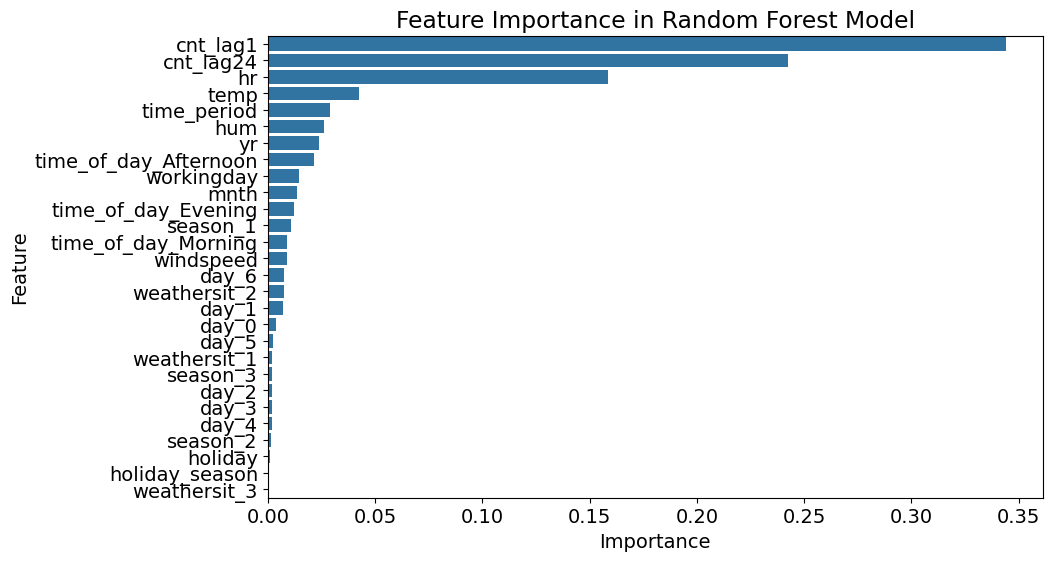

In [128]:
feature_importances = grid_search_forest.best_estimator_.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importance in Random Forest Model")
plt.show()

cnt_lag1 here you can see that the values ​​for the past hour have the greatest influence on the prediction. In 2nd place is cnt_lag24 (the number of calls during the same hour of the previous day). But if the model excessively depends only on these two features, then there is a risk of overfitting.

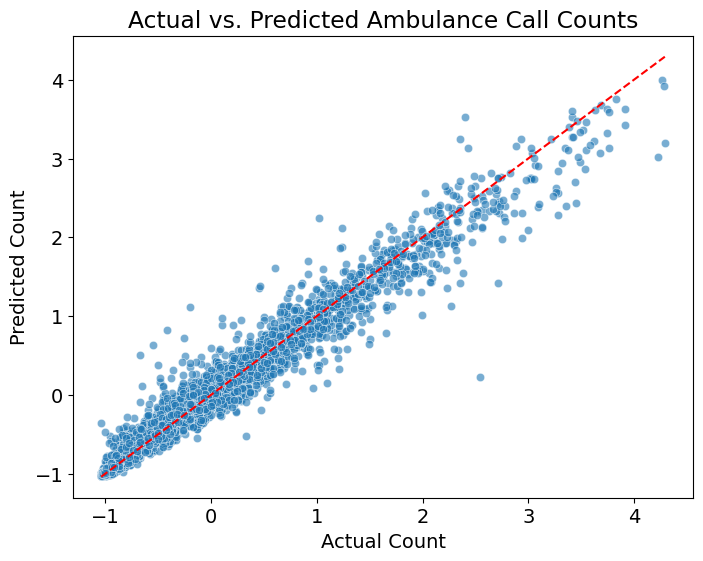

In [129]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_random_forest, alpha=0.6)
plt.xlabel("Actual Count")
plt.ylabel("Predicted Count")
plt.title("Actual vs. Predicted Ambulance Call Counts")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.show()

Points located close to the ideal prediction (red line), indicating high accuracy of the model.

## XGBoost

In [130]:
grid_params_xgb = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [3, 5],                      
    'subsample': [0.8, 1.0],                  
    'colsample_bytree': [0.8, 1.0],           
    'reg_alpha': [0, 0.1, 1],                 
    'reg_lambda': [0.5, 5, 10]   
}

xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search_xgb = GridSearchCV(estimator=xgboost_model, param_grid=grid_params_xgb, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)


Here I still use L1 L2 Regularization
- L1 penalizes large model coefficients
- L2 controls the complexity of the model

In [131]:
grid_search_xgb.fit(X_train, y_train)
y_pred_xgb = grid_search_xgb.predict(X_test)
 

In [132]:
regression_metrics(y_test, y_pred_xgb, "XGBoost")

Performance of XGBoost:
Mean Absolute Error (MAE): 0.11876048982556482
Root Mean Squared Error (RMSE): 0.19140702013079405
R-squared (R²): 0.9632907507030889


The XGBoost model performed excellently and outperformed all models in all key metrics.

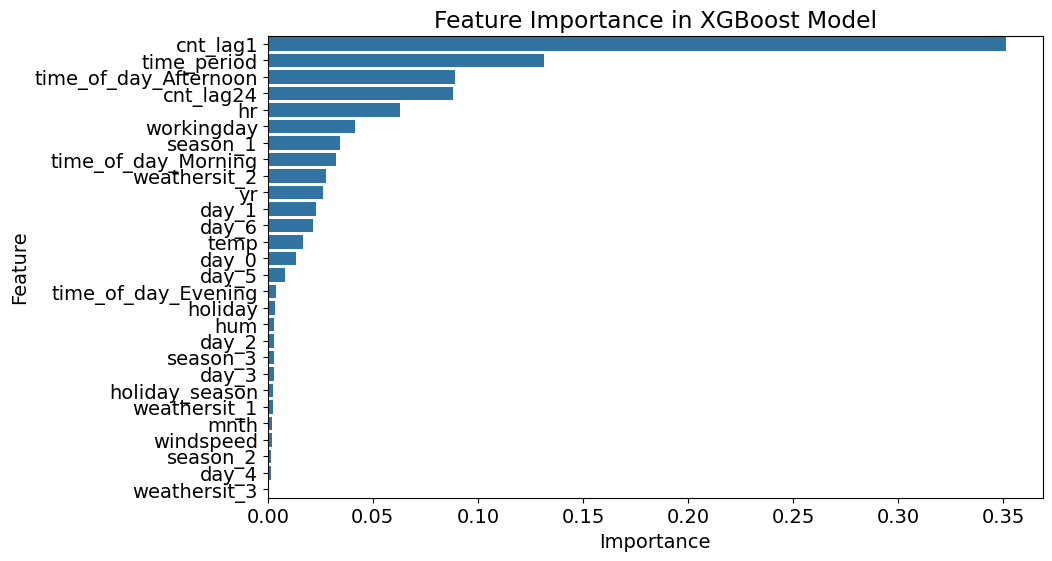

In [133]:
feature_importances = grid_search_xgb.best_estimator_.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importance in XGBoost Model")
plt.show()

XGBoost better distributes the importance of temporal and categorical features

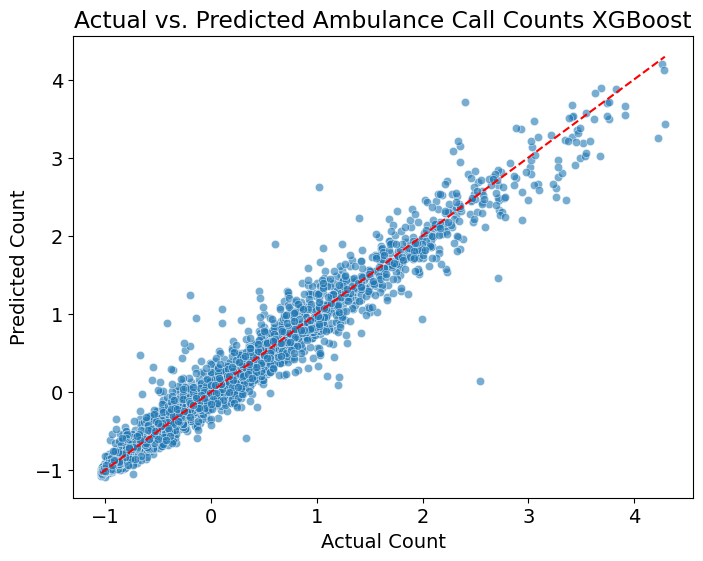

In [134]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.6)
plt.xlabel("Actual Count")
plt.ylabel("Predicted Count")
plt.title("Actual vs. Predicted Ambulance Call Counts XGBoost")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.show()

## Gradient Boosting

In [135]:
param_grid_gradient_boosting = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 1.0],
}

grid_search_gradient_boosting = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid_gradient_boosting,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1
)


grid_search_gradient_boosting.fit(X_train, y_train)


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5], 'n_estimators': [50, 100, 200],
                         'subsample': [0.7, 0.8, 1.0]},
             scoring='neg_mean_squared_error')

In [136]:
y_pred_gradient_boosting = grid_search_gradient_boosting.predict(X_test)



In [137]:
regression_metrics(y_test, y_pred_gradient_boosting, "Gradient Boosting")

Performance of Gradient Boosting:
Mean Absolute Error (MAE): 0.12304045705947844
Root Mean Squared Error (RMSE): 0.19774528969840624
R-squared (R²): 0.9608193105547141


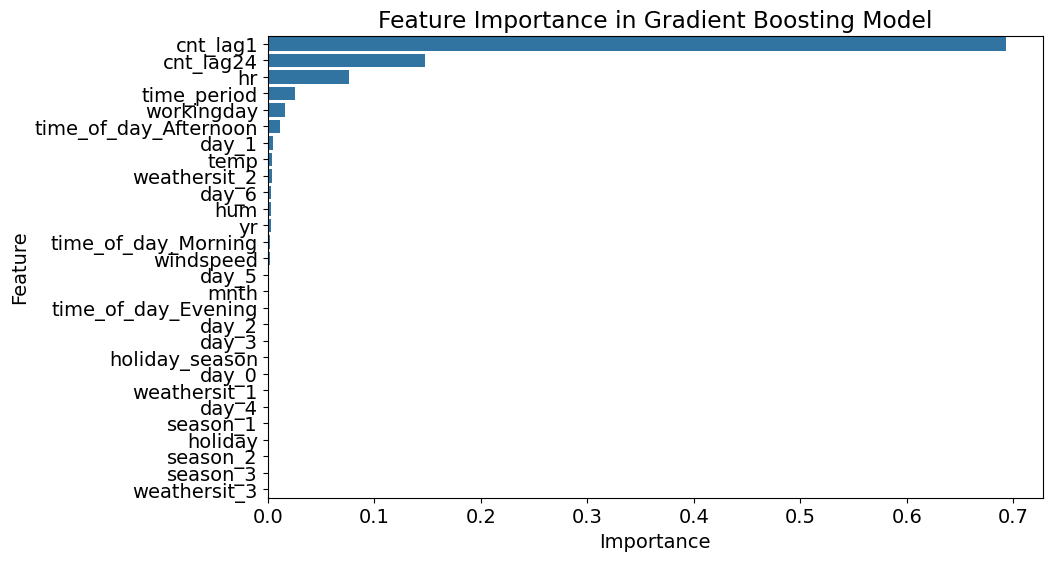

In [138]:
feature_importances = grid_search_gradient_boosting.best_estimator_.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importance in Gradient Boosting Model")
plt.show()

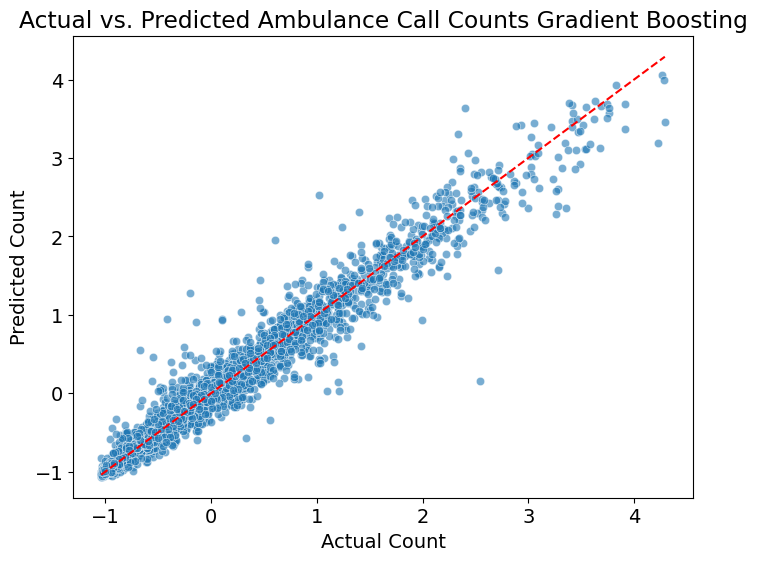

In [139]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_gradient_boosting, alpha=0.6)
plt.xlabel("Actual Count")
plt.ylabel("Predicted Count")
plt.title("Actual vs. Predicted Ambulance Call Counts Gradient Boosting")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.show()

Gradient Boosting combines decision trees into a strong model, gradually reducing the errors of previous iterations. The model shows good results but relies too much on 1 feature

## AdaBoost


In [140]:
param_grid_adaboost = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'estimator__max_depth': [2, 3, 4],
    'estimator__min_samples_split': [2, 5, 10],
}

grid_search_adaboost = GridSearchCV(
    estimator=AdaBoostRegressor(estimator=DecisionTreeRegressor(), random_state=42),
    param_grid=param_grid_adaboost,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1
)


grid_search_adaboost.fit(X_train, y_train)

y_pred_adaboost = grid_search_adaboost.predict(X_test)

regression_metrics(y_test, y_pred_adaboost, "AdaBoost")

Performance of AdaBoost:
Mean Absolute Error (MAE): 0.24810754165504856
Root Mean Squared Error (RMSE): 0.337988928343037
R-squared (R²): 0.8855371046284873


- MAE is quite high compared to other models, which means that there are larger errors in the predictions
- RMSE is the highest among all models
- R² 0.8855371046284873, in principle, a good indicator, but the lowest among all models

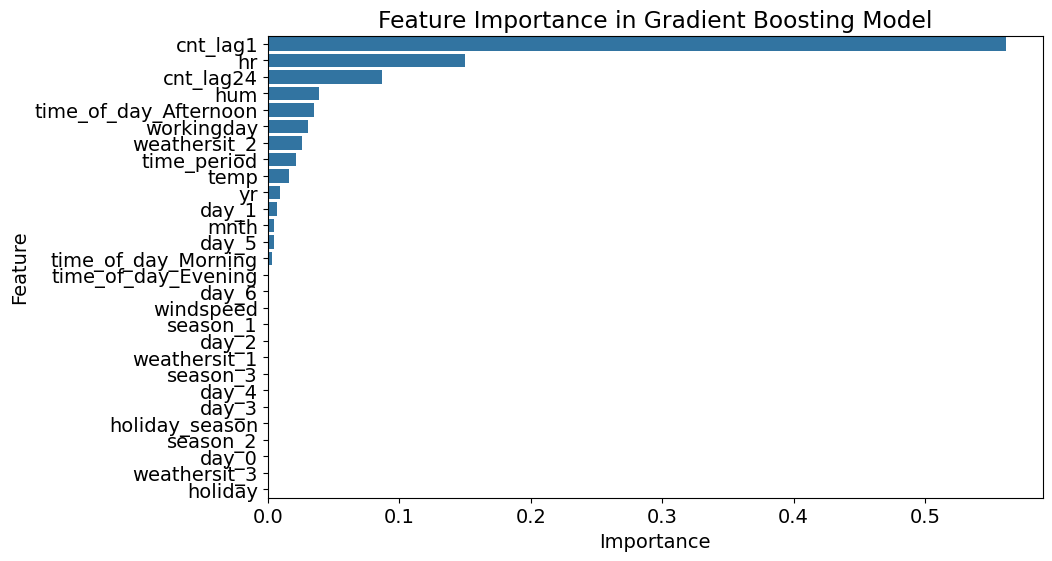

In [141]:
feature_importances = grid_search_adaboost.best_estimator_.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importance in Gradient Boosting Model")
plt.show()

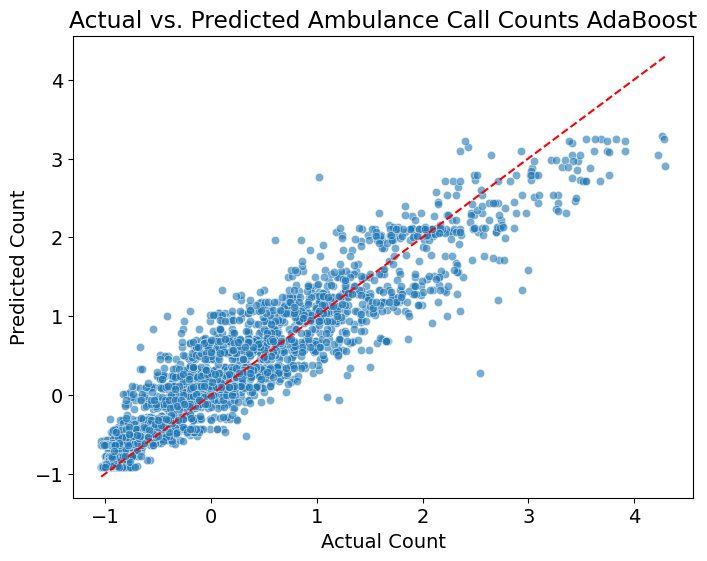

In [142]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_adaboost, alpha=0.6)
plt.xlabel("Actual Count")
plt.ylabel("Predicted Count")
plt.title("Actual vs. Predicted Ambulance Call Counts AdaBoost")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.show()

The graph shows a larger spread of points and less symmetry

## Conclusion for Regression

- XGBoost proved to be the best model for predicting the number of calls because it works efficiently with complex data and shows the most accurate results.
- AdaBoost, failed to show competitive accuracy in this analysis.

Therefore, for the prediction task, XGBoost is clearly the best choice.

# Anomaly Detection

I will identify anomalies using
- Z-Score, where points with a deviation of more than 3 standard deviations are considered abnormal
- Isolation Forest which isolates anomalies, evaluating them as points with low density
- Local Outlier Factor identifies anomalies based on local data density

In [143]:
def plot_anomalies(mnth_anomalies, holiday_anomalies, workingday_anomalies):
    fig, axs = plt.subplots(3, 1, figsize=(12, 18), constrained_layout=True)

    axs[0].bar(mnth_anomalies.index, mnth_anomalies.values, color="blue", alpha=0.7)
    axs[0].set_title("Anomalies by Month")
    axs[0].set_xlabel("Month")
    axs[0].set_ylabel("Count of Anomalies")
    axs[0].set_xticks(range(1, 13))
    axs[0].set_xticklabels(
        ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    )
    axs[0].grid(axis='y')

    axs[1].bar(holiday_anomalies.index, holiday_anomalies.values, color="green", alpha=0.7)
    axs[1].set_title("Anomalies by Holiday")
    axs[1].set_xlabel("Holiday (0 = Non-Holiday, 1 = Holiday)")
    axs[1].set_ylabel("Count of Anomalies")
    axs[1].set_xticks([0, 1])
    axs[1].grid(axis='y')

    axs[2].bar(workingday_anomalies.index, workingday_anomalies.values, color="red", alpha=0.7)
    axs[2].set_title("Anomalies by Working Day")
    axs[2].set_xlabel("Working Day (0 = Weekend/Holiday, 1 = Working Day)")
    axs[2].set_ylabel("Count of Anomalies")
    axs[2].set_xticks([0, 1])
    axs[2].grid(axis='y')

    plt.tight_layout()
    plt.show()

Here I have created a function to visualize the number of anomalies in different categories. The function generates three separate graphs:
 - the first shows the distribution of anomalies by month
 - the second - on holidays
 - the third — on working days and weekends.

In [144]:
def visualize_anomalies(X_test, y_test):
    plt.figure(figsize=(15, 6))
    plt.scatter(X_test.index, y_test, label='Ambulance Calls', color='blue', alpha=0.6)
    plt.scatter(
        X_test[X_test['anomaly'] == 1].index,
        y_test[X_test['anomaly'] == 1],
        color='red',
        label='Anomalies',
        marker='o',
    )
    plt.title('Ambulance Calls with Detected Anomalies')
    plt.xlabel('Index')
    plt.ylabel('Count of Ambulance Calls')
    plt.legend()
    plt.grid(True)
    plt.show()

This function is needed in order to visualize the data together with the anomalies.

## Z-score

In [145]:
motorbike_ambulance_calls['z_score'] = (motorbike_ambulance_calls['cnt'] - motorbike_ambulance_calls['cnt'].mean()) / motorbike_ambulance_calls['cnt'].std()

anomalies = motorbike_ambulance_calls[np.abs(motorbike_ambulance_calls['z_score']) > 2.3]
print("Number of anomalies:", anomalies.shape[0])

X_test['anomaly'] = anomalies['z_score']


X_test = X_test.copy()
X_test['anomaly'] = 0

X_test.loc[anomalies.index.intersection(X_test.index), 'anomaly'] = 1


mnth_anomalies = anomalies['mnth'].value_counts().sort_index()
holiday_anomalies = anomalies['holiday'].value_counts().sort_index()
workingday_anomalies = anomalies['workingday'].value_counts().sort_index()


Number of anomalies: 643


Here, the Z-score is used to calculate the standard deviation of the values ​​in the cnt column. Points with an absolute value of Z-score greater than 2.3 are defined as anomalies.

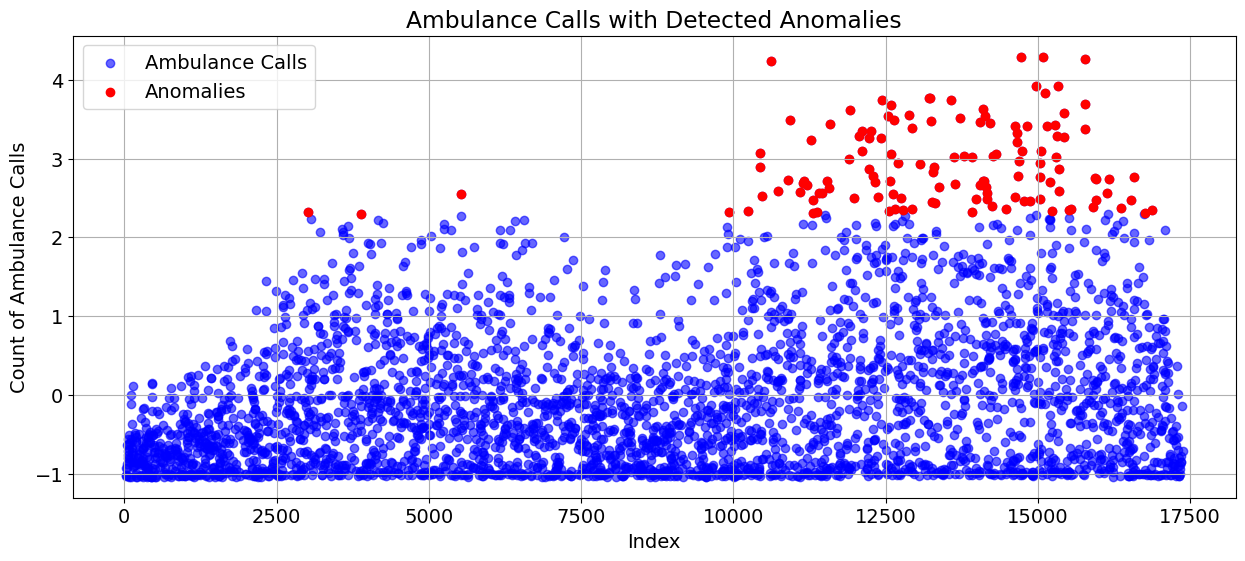

In [146]:
visualize_anomalies(X_test, y_test)

The anomalies are outside the general cluster of normal points and are concentrated in the upper part of the graph, indicating a significantly higher number of calls.

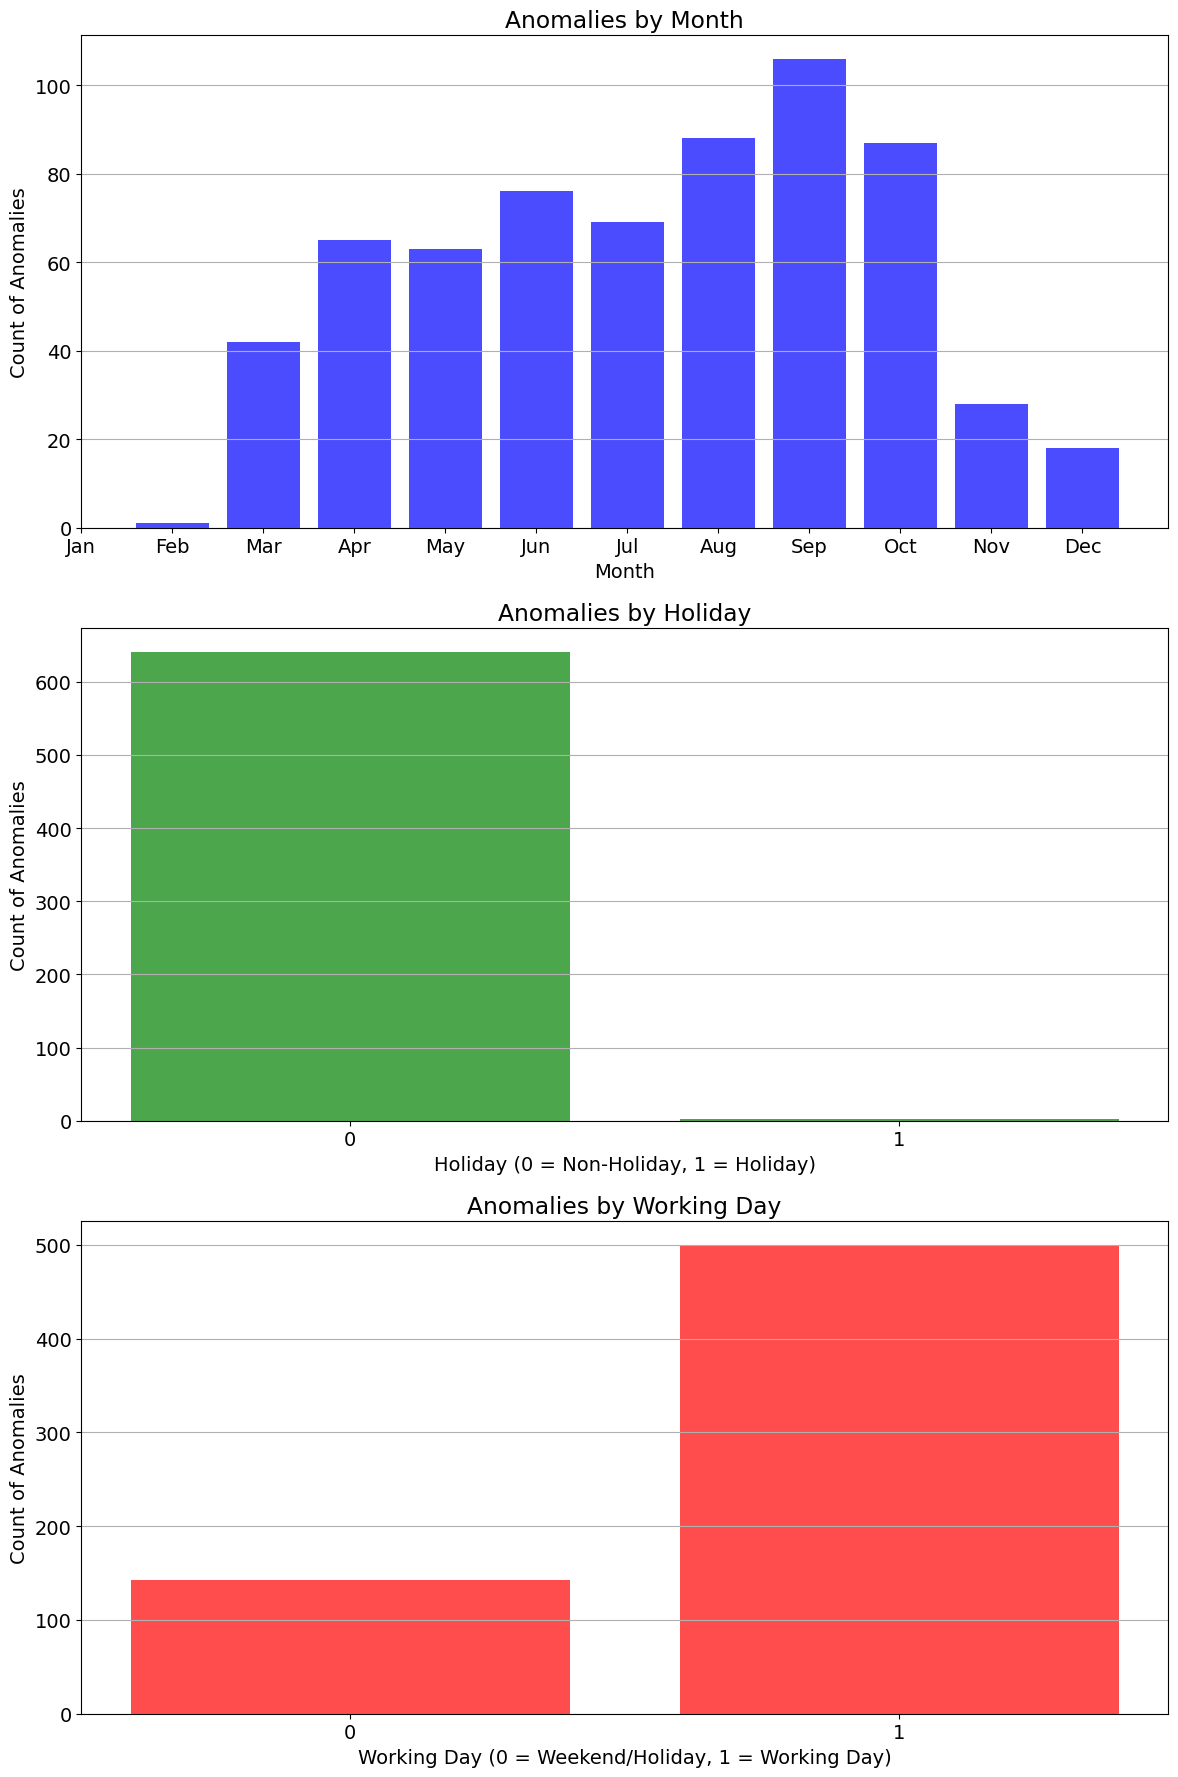

In [147]:
plot_anomalies(mnth_anomalies, holiday_anomalies, workingday_anomalies)

- The largest number of anomalies is observed in September and October, which may indicate circumstances such as autumn weather conditions that caused a sharp increase in calls.
- The second graph shows that the vast majority of anomalies occur on non-holiday days.
- the 3rd graph in shows that the majority of anomalies occur on working days.

## Isolation Forest

In [148]:
isolation_forest = IsolationForest(random_state=42, contamination=0.08, n_estimators=100, max_features=10, max_samples=60, n_jobs=-1)
isolation_forest.fit(X_train)

X_test_clean = X_test.drop(columns=['anomaly'], errors='ignore')

isolation_forest_preds_test = isolation_forest.predict(X_test_clean)

isolation_forest_preds_test = np.array([1 if x == -1 else 0 for x in isolation_forest_preds_test])

motorbike_ambulance_calls.loc[motorbike_ambulance_calls.index[-len(isolation_forest_preds_test):], 'anomaly'] = isolation_forest_preds_test
X_test['anomaly'] = isolation_forest_preds_test

anomalies = X_test[X_test['anomaly'] == 1]
isolation_forest_anomalies = anomalies.shape[0]
normal_data = len(isolation_forest_preds_test) - isolation_forest_anomalies

print("Number of anomalies:", isolation_forest_anomalies)
print("Number of normal data:", normal_data)

mnth_anomalies = anomalies['mnth'].value_counts().sort_index()
holiday_anomalies = anomalies['holiday'].value_counts().sort_index()
workingday_anomalies = anomalies['workingday'].value_counts().sort_index()

Number of anomalies: 295
Number of normal data: 3176


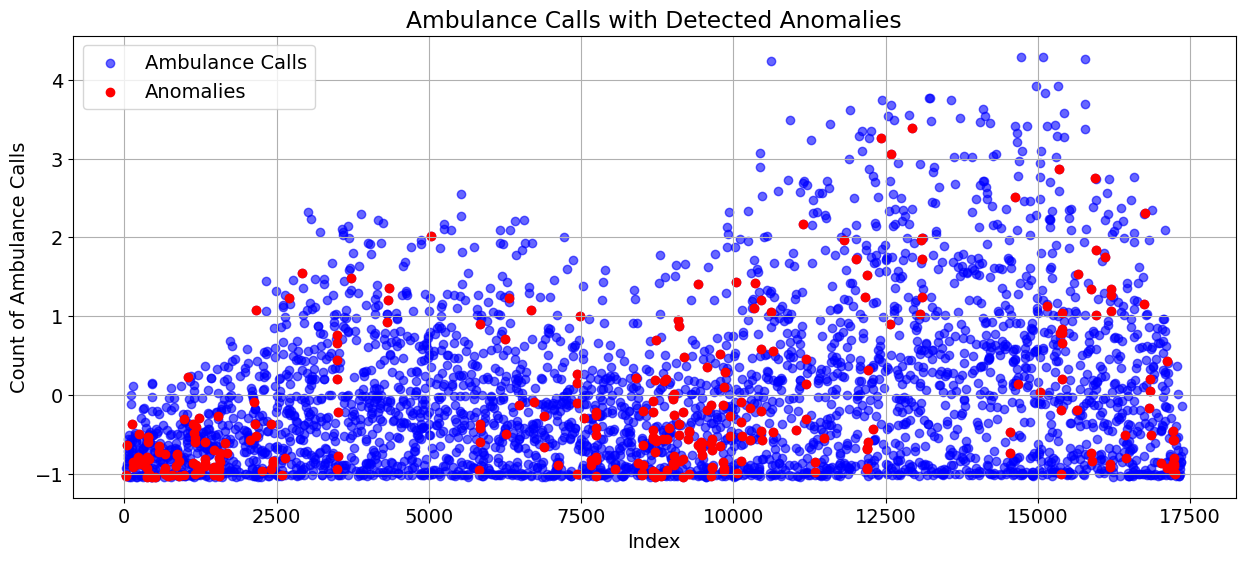

In [149]:
visualize_anomalies(X_test, y_test)

The graph shows three conditional clusters
- the 1st cluster may represent periods with a minimum load, for example, at night or on weekends
- In the 2nd cluster, anomalies may be associated with deviations during normal loading times, for example, during peak hours
- the 3rd cluster reflects rare events, they can be emergency situations, seasonal surges or other abnormal events

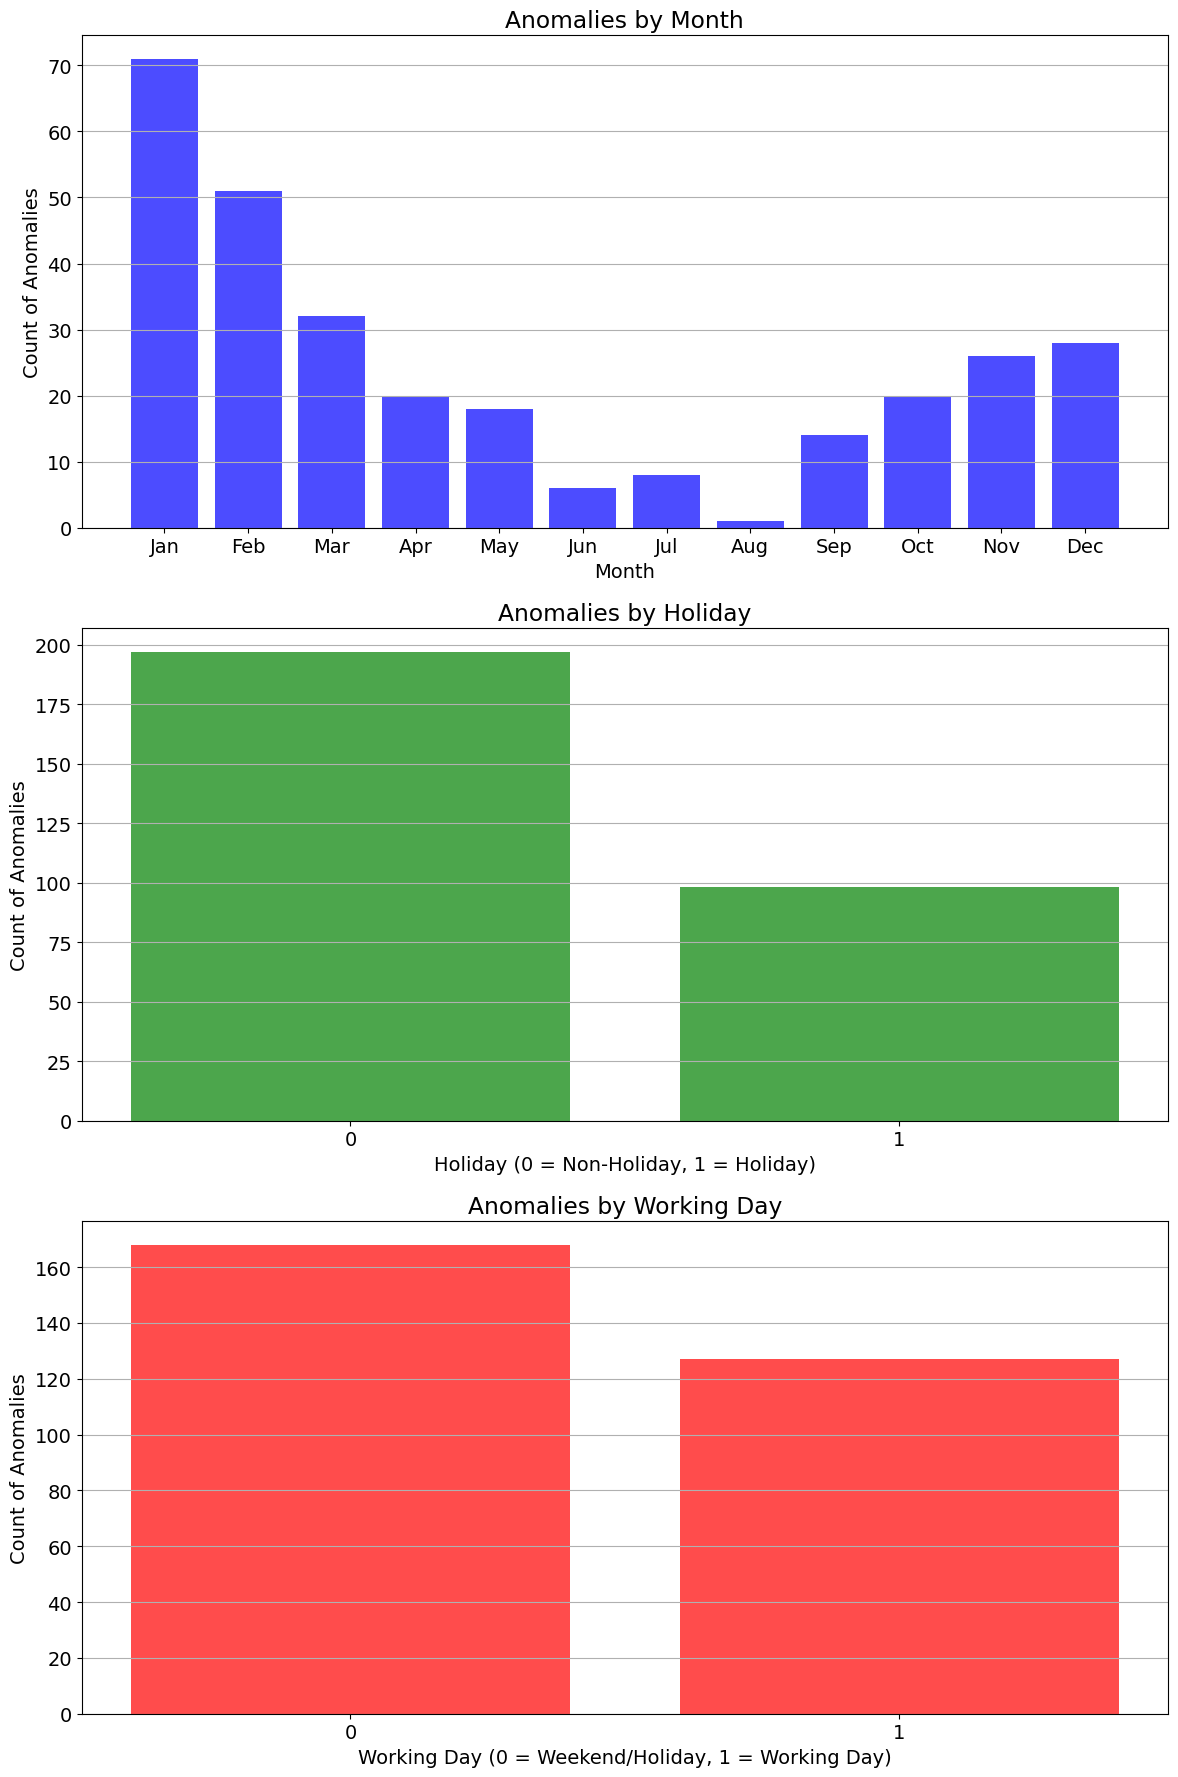

In [150]:
plot_anomalies(mnth_anomalies, holiday_anomalies, workingday_anomalies)

The largest number of anomalies occurs in January and February, and the smallest - in summer, which may indicate the seasonal nature of the events.
Anomalies occur more often on non-holidays, but unlike Z-score Isolation Forest detected anomalies on holidays

## Local Outlier Factor

LOF compares the density of a point with the density of its neighbors. If the density of a point is significantly lower than that of its neighbors, it is considered an anomaly

In [151]:


lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.08,
    metric='euclidean',
    algorithm='auto',
    leaf_size=5
)

lof.fit(X_train)

lof_preds_test = lof.fit_predict(X_test)

lof_preds_test = np.array([1 if x == -1 else 0 for x in lof_preds_test])

motorbike_ambulance_calls.loc[motorbike_ambulance_calls.index[-len(lof_preds_test):], 'anomaly'] = lof_preds_test

X_test['anomaly'] = lof_preds_test

anomalies = X_test[X_test['anomaly'] == 1]
lof_anomalies = anomalies.shape[0]
normal_data = len(lof_preds_test) - lof_anomalies

print("Number of anomalies:", lof_anomalies)
print("Number of normal data:", normal_data)

mnth_anomalies = anomalies['mnth'].value_counts().sort_index()
holiday_anomalies = anomalies['holiday'].value_counts().sort_index()
workingday_anomalies = anomalies['workingday'].value_counts().sort_index()


Number of anomalies: 278
Number of normal data: 3193


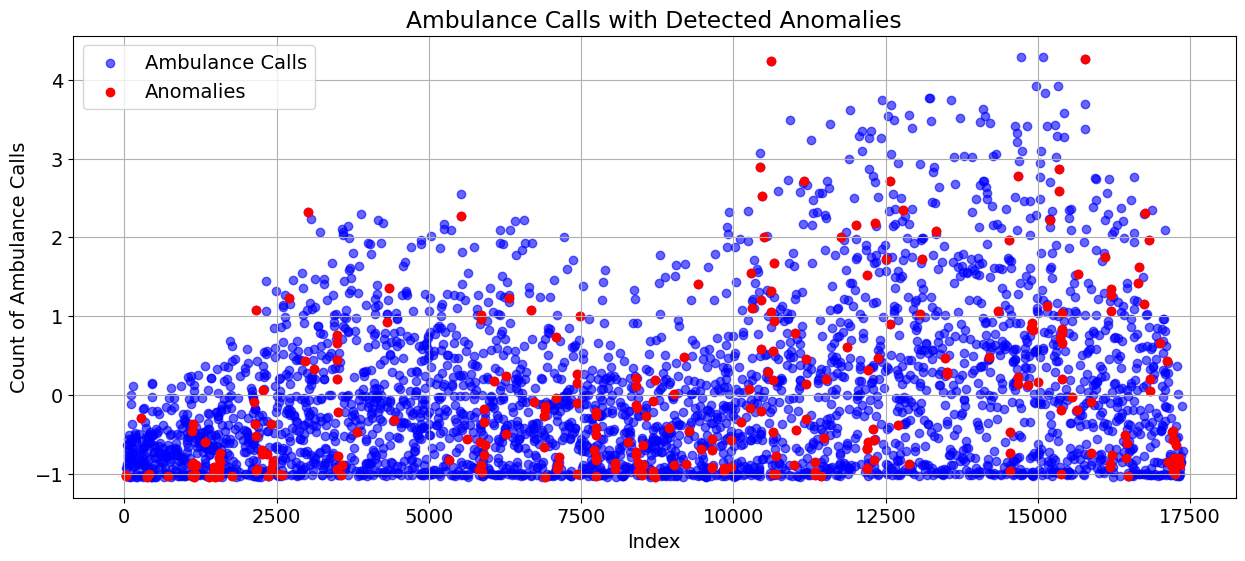

In [152]:
visualize_anomalies(X_test, y_test)

It is possible that these anomalies correspond to unusual events such as sudden load peaks or irregular events, but it is worth checking whether all the red dots are really anomalies.

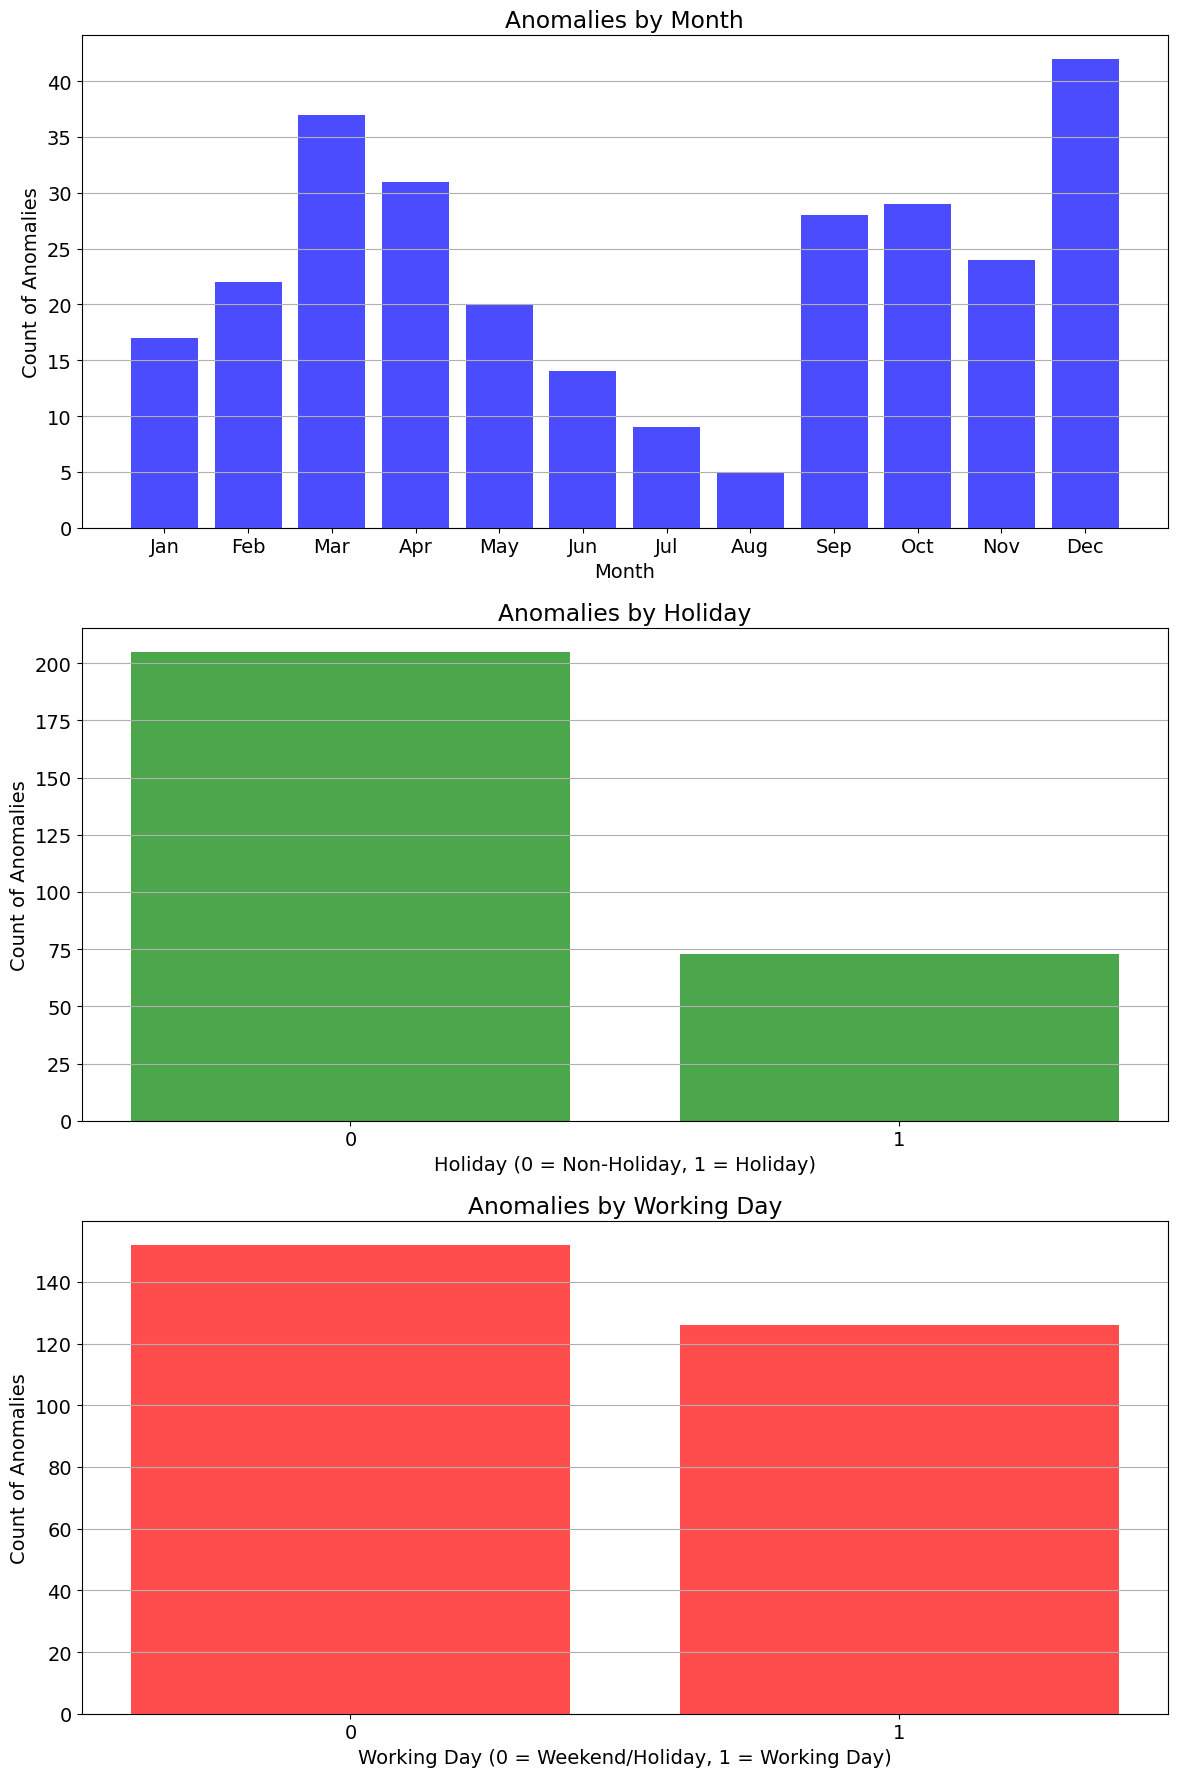

In [153]:
plot_anomalies(mnth_anomalies, holiday_anomalies, workingday_anomalies)

- The largest number of anomalies is observed in March and December
- Most of the anomalies occur on non-holiday days
- The number of anomalies on working days and weekends is approximately the same.